# Metrics' Computation using GroupBy

Our project is divided in two branches, the first works with Dask data frames using a groupby operation, the second handles Dask bags and it is characterized by a foldby.

Car records are imported, cleaned, and associated with the nearest BS. In order to extract the most important features from the dataset, we compute some metrics and we superimpose them on a map of the city. This can be done by applying **groupby + aggregate** functions to split the total dataset into meaningful groups and to apply an aggregation to extract some high-level information from each of them (e.g., mean, count, etc...).
This computation is expensive but it reduces considerably the dataset, so we can consider to save the intermediate results in memory to speed up the following calculations. The considered metrics are:

1. **Mean time spent in each BS:**
    1. Groupby cars' and BS' identifiers and calculate minimum time (time of first car-BS connection) and maximum time (time of last car-BS connection): `groupby(['base_ID', 'ID']).time.agg(['max','min'])`
    2. Compute total duration of the connection: `diff_time = max - min`
    3. Groupby BS and compute the mean value of all the connections of that BS: `groupby('base_ID').mean()`


2. **Maximum number of cars connected at the same time to a BS:**
    1. Groupby time and BS' identifiers and count cars in each group: `groupby(['time', 'base_ID']).ID.count()`
    2. Groupby BS and compute the maximum value of cars connected along the day: `groupby('base_ID').ID.max()`


3. **Total number of connections to each BS in the whole day** (a "connection" is defined as a car-BS pair at a given time, and the same car-BS pair at different times correspond to different connections):
    1. Groupby time and BS' identifiers and count cars in each group (use the same result obtained in 2A)
    2. Groupby BS and compute the sum of the `n_cars` column (number of cars connected):     `groupby('base_ID').n_cars.sum()`
    
    
4. **Total number of cars in each BS in the whole day:**
    1. Groupby cars' and BS' identifiers like in 1A)
    2. Groupby BS' identifiers and count the cars' identifier column: `groupby('base_ID').ID.count()`


In [3]:
from dask.distributed import Client, SSHCluster
cluster = SSHCluster(
     ["10.67.22.41", "10.67.22.41", "10.67.22.145", "10.67.22.146", '10.67.22.160', '10.67.22.253'],
     worker_options={"nthreads": 1, 'n_workers':4},
     scheduler_options={"dashboard_address": ":8220"}
)
client = Client(cluster)

distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.41:36037
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.41:44501'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.41:39877'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.41:39949'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.41:42017'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.146:36497'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at:

distributed.deploy.ssh - INFO - distributed.worker - INFO -               Threads:                          1
distributed.deploy.ssh - INFO - distributed.worker - INFO -                Memory:                   1.94 GiB
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Local Directory: /root/dask-worker-space/worker-zmwdm294
distributed.deploy.ssh - INFO - distributed.worker - INFO - -------------------------------------------------
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.145:35209
distributed.deploy.ssh - INFO - distributed.worker - INFO -          Listening to:   tcp://10.67.22.145:35209
distributed.deploy.ssh - INFO - distributed.worker - INFO -          dashboard at:         10.67.22.145:33953
distributed.deploy.ssh - INFO - distributed.worker - INFO - Waiting to connect to:    tcp://10.67.22.41:36037
distributed.deploy.ssh - INFO - distributed.worker - INFO - -----------------------------------------------

distributed.deploy.ssh - INFO - distributed.worker - INFO -               Threads:                          1
distributed.deploy.ssh - INFO - distributed.worker - INFO -                Memory:                   1.94 GiB
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Local Directory: /root/dask-worker-space/worker-qigl0a_6
distributed.deploy.ssh - INFO - distributed.worker - INFO - -------------------------------------------------
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.253:42363
distributed.deploy.ssh - INFO - distributed.worker - INFO -          Listening to:   tcp://10.67.22.253:42363
distributed.deploy.ssh - INFO - distributed.worker - INFO -          dashboard at:         10.67.22.253:45287
distributed.deploy.ssh - INFO - distributed.worker - INFO - Waiting to connect to:    tcp://10.67.22.41:36037
distributed.deploy.ssh - INFO - distributed.worker - INFO - -----------------------------------------------

In [4]:
client

<Client: 'tcp://10.67.22.41:36037' processes=10 threads=10, memory=19.43 GiB>

In [1]:
import dask
import dask.dataframe as dd
import io
from functools import partial

from fsspec.core import open_files
from tlz import concat

from dask.bag.core import from_delayed
from dask.bytes import read_bytes
from dask.delayed import delayed
from dask.utils import parse_bytes, system_encoding
import pandas as pd
import re
import dask.bag as db
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [7]:
db_travel = db.read_text('/dataNFS/koln.txt', blocksize='9.455MB')

In [8]:
def clean_round_row(row):
    
    pattern = '[0-9]+\.?[0-9]*'
    findings = re.findall(pattern, row[:-1])
    
    if(len(findings) == len(row[:-1].split(' '))):
        round_findings = [round(float(x),4) for x in findings]
        return round_findings
    else:
        return []

In [9]:
db_cleaned = db_travel.map(clean_round_row).filter(lambda x: len(x)>0)

In [10]:
dask_df = db_cleaned.to_dataframe(meta = {'time':int, 'ID':int, 'x':float, 'y':float, 'velocity':float})

<img src="images/dask_df.png">

In [2]:
#upper, lower, right, left
upper, lower, right, left = pd.read_csv("/dataNFS/grid_params.csv", header=0)[['upper','lower', 'right','left']].values[0]

# delta_x, delta_y
delta_x, delta_y = pd.read_csv("/dataNFS/grid_params.csv", header=0)[['delta_x','delta_y']].values[0]

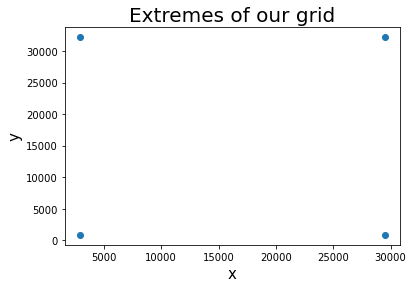

In [3]:
plt.scatter(x=[right, left, right, left],y=[lower, upper, upper, lower] )
plt.title('Extremes of our grid', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.show()

In [4]:
df_BS = pd.read_csv("/dataNFS/df_BS.csv", header=0)
df_BS.head()

x            y  base_ID  horizontal  vertical
0   3769.0203  1826.646344        0           0         0
1   5427.4841  1826.646344        1           1         0
2   7085.9479  1826.646344        2           2         0
3   8744.4117  1826.646344        3           3         0
4  10402.8755  1826.646344        4           4         0

In [5]:
df_grid = pd.read_csv("/dataNFS/df_grid.csv", header=0)
df_grid.head()

x        y
0  2939.7884  847.189
1  4598.2522  847.189
2  6256.7160  847.189
3  7915.1798  847.189
4  9573.6436  847.189

## Direct matching

With the creation of the regular grid, the matching between each car and the nearest BS is computed directly by defining the new variables, `horizontal` and `vertical`, that uniquely identifies the BS cell in which each car is. After the matching the dataframe has the following structure:

| time (int) | ID (int) | x (float) | y (float) | velocity (float) | horizontal (int) | vertical (int) | base_ID (int) |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Time variable in seconds | Car identifier | x-coordinate of the car | y-coordinate of the car | Velocity of the car | Horizontal index | Vertical index | BS identifier |

In [17]:
dask_df['horizontal'] = (dask_df['x'] - left)//delta_x 
dask_df['vertical'] = (dask_df['y'] - lower)//delta_y 

In [18]:
def square_match(row):
    
    base_targets = df_BS[df_BS['horizontal'] == row.horizontal]
    base_targets = base_targets[base_targets['vertical'] == row.vertical]
    base_targets = base_targets['base_ID'].values
    
    if len(base_targets) == 1:
        return base_targets[0]
    
    else: return -1

In [19]:
dask_df['base_ID'] = dask_df.apply(square_match, axis=1, meta=int)

dask_df_filt = dask_df[dask_df['base_ID'] >= 0]

/root/anaconda3/lib/python3.9/site-packages/dask/dataframe/core.py:6169: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(


## Metrics' computation

After computing once our metrics, the results were stored in csv files which are imported below.

In [20]:
grouped_df = dask_df_filt.groupby(['base_ID', 'ID']).time.agg(['max','min'], split_out=4)

<img src="images/grouped_df.png" width=400>

In [8]:
diff_time = grouped_df['max'] - grouped_df['min']

<img src="images/diff_time.png" width=400>

In [ ]:
# Metrics' computation

mean_per_base, car_per_base = dask.compute(diff_time.groupby(by='base_ID').mean(split_out=4), 
                                                   dask_df_filt.groupby(['time', 'base_ID']).ID.count(split_out=4))
                                                     

<img src="images/groupbys.png" width=500>

1. **Mean time spent in each BS:** `mean_per_base`

In [18]:
# Actual computation
mean_per_base = pd.DataFrame(mean_per_base, columns=['mean_time'])

In [20]:
# csv import after the first computation
mean_per_base = pd.read_csv('/dataNFS/mean_per_base.csv', header=0)

In [21]:
mean_per_base.set_index('base_ID', inplace=True)

In [25]:
joined_mean_time =df_BS.join(mean_per_base, on='base_ID', rsuffix='_mean', lsuffix='_BS', how='left')


In [28]:
joined_mean_time.head(10)

x            y  base_ID  horizontal  vertical   mean_time
0   3769.0203  1826.646344        0           0         0         NaN
1   5427.4841  1826.646344        1           1         0         NaN
2   7085.9479  1826.646344        2           2         0         NaN
3   8744.4117  1826.646344        3           3         0         NaN
4  10402.8755  1826.646344        4           4         0         NaN
5  12061.3393  1826.646344        5           5         0   80.500000
6  13719.8031  1826.646344        6           6         0  133.500000
7  15378.2669  1826.646344        7           7         0   69.000000
8  17036.7307  1826.646344        8           8         0   36.115942
9  18695.1945  1826.646344        9           9         0   65.064000

In [29]:
import matplotlib.image as mpimg
img = mpimg.imread('/dataNFS/real_map.png') # street layout of the Cologne urban area

extent = [left, right, lower, upper]

gridsize=(1,2)

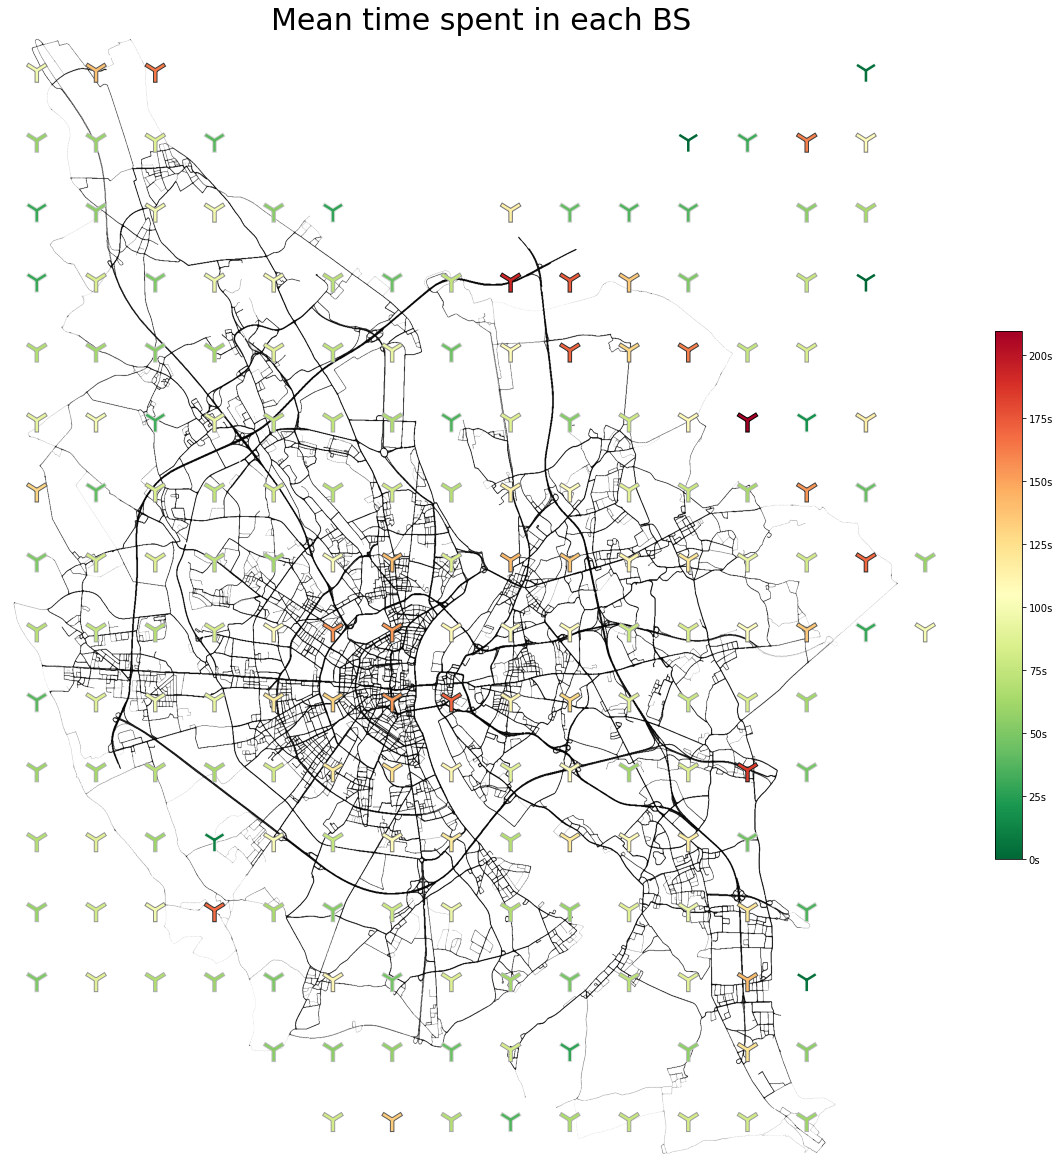

In [30]:
fig, ax = plt.subplots(figsize=(40, 40))




ax = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax.imshow(img, extent=extent)



scatter = ax.scatter(x=joined_mean_time['x'], y=joined_mean_time['y'],
                     c=joined_mean_time['mean_time'], cmap = cm.get_cmap('RdYlGn').reversed(),
                     s = 500, marker = "1",linewidths=2.5, zorder=5)
plt.colorbar(scatter, ax=ax, format='%ds', fraction=0.026, pad=0.04)
scatter = ax.scatter(x=joined_mean_time['x'], y=joined_mean_time['y'],
                     c=joined_mean_time['mean_time'], cmap = cm.get_cmap('gist_gray').reversed(),
                     s = 600, marker = "1",linewidths=4.5, zorder=1)




ax.set_title('Mean time spent in each BS', fontsize=30)


plt.axis('off')
plt.show()

The mean time spent in each Base Station reveals how highly visited areas (e.g., city centre) can be crossed, on average, faster than some area in the suburbs.

2. **Maximum number of cars connected at the same time to a BS:** `max_car_per_base`

In [20]:
# Actual computation
car_per_base = pd.DataFrame(car_per_base)

In [27]:
car_per_base = pd.DataFrame(car_per_base).to_csv('/dataNFS/Nick_df.csv')   #needed also for streaming

In [31]:
# csv import after the first computation
car_per_base = pd.read_csv('/dataNFS/Nick_df.csv', header=0)

In [32]:
max_car_per_base = car_per_base.groupby(by='base_ID').max()

In [38]:
joined_car_per_base = df_BS.join(max_car_per_base, on='base_ID', rsuffix='_max', lsuffix='_BS', how='left')

In [40]:
joined_car_per_base.head(10)

x            y  base_ID  horizontal  vertical     time  n_cars
0   3769.0203  1826.646344        0           0         0      NaN     NaN
1   5427.4841  1826.646344        1           1         0      NaN     NaN
2   7085.9479  1826.646344        2           2         0      NaN     NaN
3   8744.4117  1826.646344        3           3         0      NaN     NaN
4  10402.8755  1826.646344        4           4         0      NaN     NaN
5  12061.3393  1826.646344        5           5         0  66134.0     1.0
6  13719.8031  1826.646344        6           6         0  66116.0     1.0
7  15378.2669  1826.646344        7           7         0  65983.0     1.0
8  17036.7307  1826.646344        8           8         0  77375.0     2.0
9  18695.1945  1826.646344        9           9         0  83815.0     4.0

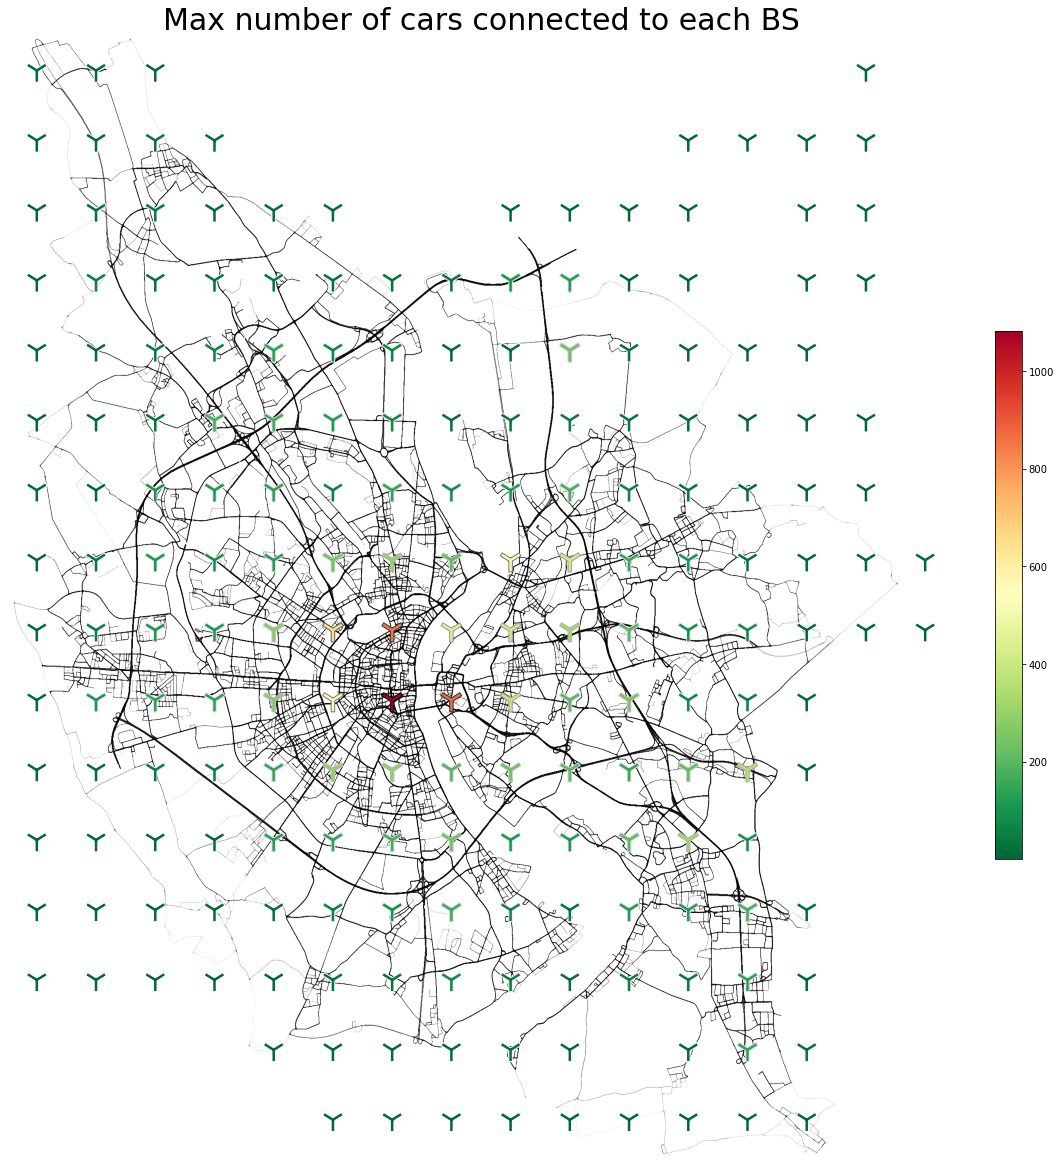

In [41]:
fig, ax = plt.subplots(figsize=(40, 40))



ax = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax.imshow(img, extent=extent)



scatter = ax.scatter(x=joined_car_per_base['x'], y=joined_car_per_base['y'],
                     c=joined_car_per_base['n_cars'], cmap = cm.get_cmap('RdYlGn').reversed(),
                     s = 500, marker = "1",linewidths=2.5, zorder=5)
plt.colorbar(scatter, ax=ax, fraction=0.026, pad=0.04)
scatter = ax.scatter(x=joined_car_per_base['x'], y=joined_car_per_base['y'],
                     c=joined_car_per_base['n_cars'], cmap = cm.get_cmap('gist_gray').reversed(),
                     s = 600, marker = "1",linewidths=4.5, zorder=1)




ax.set_title('Max number of cars connected to each BS', fontsize=30)
plt.axis('off')
plt.show()

The maximum number of cars connected at a given second is reached in the city centre with approximately $1000$ cars at the same time.

3. **Total number of connections to each BS in the whole day**: `num_con_per_base`

In [42]:
# Actual computation
num_con_per_base = car_per_base.groupby('base_ID').sum().n_cars

In [45]:
joined_num_car = df_BS.join(num_con_per_base, on='base_ID', rsuffix='_num', lsuffix='_BS', how='left')
joined_num_car.head(10)

x            y  base_ID  horizontal  vertical  n_cars
0   3769.0203  1826.646344        0           0         0     NaN
1   5427.4841  1826.646344        1           1         0     NaN
2   7085.9479  1826.646344        2           2         0     NaN
3   8744.4117  1826.646344        3           3         0     NaN
4  10402.8755  1826.646344        4           4         0     NaN
5  12061.3393  1826.646344        5           5         0   163.0
6  13719.8031  1826.646344        6           6         0   269.0
7  15378.2669  1826.646344        7           7         0   140.0
8  17036.7307  1826.646344        8           8         0  2561.0
9  18695.1945  1826.646344        9           9         0  8258.0

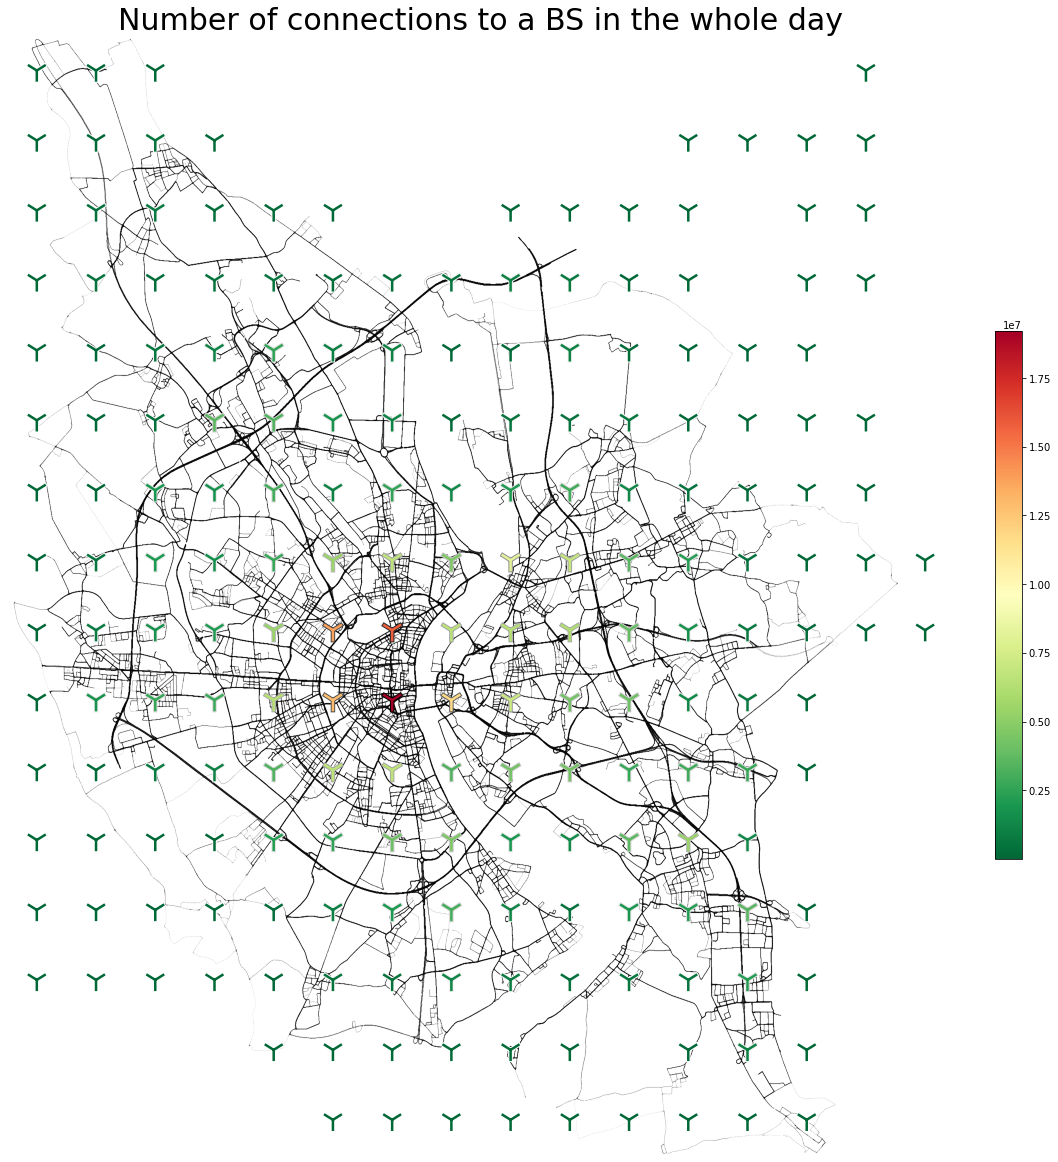

In [46]:
fig, ax = plt.subplots(figsize=(40, 40))

ax = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax.imshow(img, extent=extent)



scatter = ax.scatter(x=joined_num_car['x'], y=joined_num_car['y'],
                     c=joined_num_car['n_cars'], cmap = cm.get_cmap('RdYlGn').reversed(),
                     s = 500, marker = "1",linewidths=2.5, zorder=5)
plt.colorbar(scatter, ax=ax,  fraction=0.026, pad=0.04)
scatter = ax.scatter(x=joined_num_car['x'], y=joined_num_car['y'],
                     c=joined_num_car['n_cars'], cmap = cm.get_cmap('gist_gray').reversed(),
                     s = 600, marker = "1",linewidths=4.5, zorder=1)




ax.set_title('Number of connections to a BS in the whole day', fontsize=30)
plt.axis('off')
plt.show()

Here we visualize the number of connections for each Base Station, a maximum peak of more then $10^7$ connections is reached in the city centre.

4. **Total number of cars in each BS in the whole day:** `tot_cars_per_day`

In [47]:
# csv import after the first computation
grouped_df = pd.read_csv('/dataNFS/grouped_df.csv')

In [51]:
tot_cars_per_day = grouped_df.groupby('base_ID').ID.count()

In [52]:
joined_tot_car = df_BS.join(tot_cars_per_day, on='base_ID', rsuffix='_tot', lsuffix='_BS', how='left')

In [53]:
joined_tot_car.head(10)

x            y  base_ID  horizontal  vertical     ID
0   3769.0203  1826.646344        0           0         0    NaN
1   5427.4841  1826.646344        1           1         0    NaN
2   7085.9479  1826.646344        2           2         0    NaN
3   8744.4117  1826.646344        3           3         0    NaN
4  10402.8755  1826.646344        4           4         0    NaN
5  12061.3393  1826.646344        5           5         0    2.0
6  13719.8031  1826.646344        6           6         0    2.0
7  15378.2669  1826.646344        7           7         0    2.0
8  17036.7307  1826.646344        8           8         0   69.0
9  18695.1945  1826.646344        9           9         0  125.0

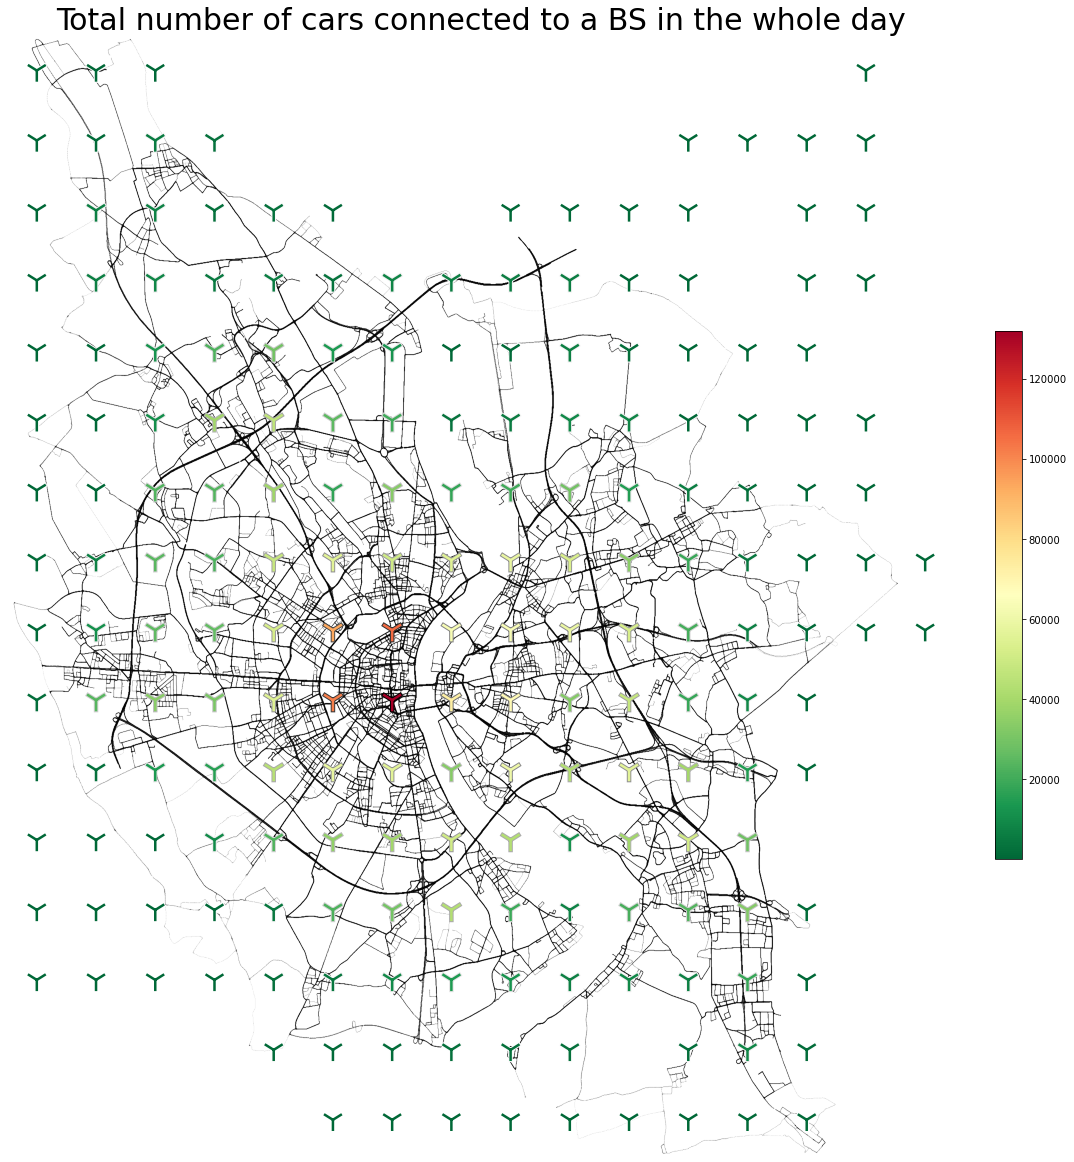

In [54]:
fig, ax = plt.subplots(figsize=(40, 40))




ax = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax.imshow(img, extent=extent)



scatter = ax.scatter(x=joined_tot_car['x'], y=joined_tot_car['y'],
                     c=joined_tot_car['ID'], cmap = cm.get_cmap('RdYlGn').reversed(),
                     s = 500, marker = "1",linewidths=2.5, zorder=5)
plt.colorbar(scatter, ax=ax,  fraction=0.026, pad=0.04)
scatter = ax.scatter(x=joined_tot_car['x'], y=joined_tot_car['y'],
                     c=joined_tot_car['ID'], cmap = cm.get_cmap('gist_gray').reversed(),
                     s = 600, marker = "1",linewidths=4.5, zorder=1)




ax.set_title('Total number of cars connected to a BS in the whole day', fontsize=30)
plt.axis('off')
plt.show()

In the above plot we can notice that in the city center the Base Station registered a higher number of connected cars with respect to the suburban area of Koln in the whole day.

## Benchmark

We conclude this part performing some benchmarks on a pruned version of the dataset (~ 5 GB), in order to inspect how the performances change with respect to the cluster's architecture: we tried different values of the main parameters of our setup, such as the number of workers (`n_workers`) for each machine, the number of threads per worker (`nthreads`) and the block size (`blocksize`) used to read and import the data.